# Lab 4

In [218]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import buttord, butter, lfilter, freqz, cheb1ord, cheby1
import pyaudio

## Helpers

In [219]:
def plot_signal(time, signal, sampling_rate, title):
    plt.figure(figsize=(15, 8))

    # Time-domain plot
    plt.subplot(2, 1, 1)
    plt.plot(time, signal, label='Signal')
    plt.title(f'Time-Domain Signal - {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.grid(True)
    plt.legend()

    # Frequency-domain plot
    spectrum = np.fft.rfft(signal)
    freq_x = np.fft.rfftfreq(len(signal), d=1 / sampling_rate)
    amplitude_spectrum = np.abs(spectrum) / len(spectrum)

    plt.subplot(2, 1, 2)
    plt.stem(freq_x, amplitude_spectrum, label='Amplitude Spectrum')
    plt.title(f'Amplitude Spectrum - {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()



def generate_sinusoidal_signal(frequency, T, sampling_rate):
    time = np.linspace(0, T, int(sampling_rate * T), endpoint=False)
    signal = np.sin(2 * np.pi * frequency * time)
    return time, signal


def generate_rectangular_pulse_signal(frequency, T, sampling_rate):
    time = np.linspace(0, T, int(sampling_rate * T))
    return time, np.sign(np.sin(2 * np.pi * frequency * time))


def generate_single_pulse(T, pulse_amplitude, pulse_duration, sampling_rate, pulse_start=0):
    time = np.linspace(0, T, int(sampling_rate * T))
    signal = np.zeros_like(time)
    start_index = int(pulse_start * sampling_rate)
    end_index = int((pulse_start + pulse_duration) * sampling_rate)
    signal[start_index:end_index] = pulse_amplitude
    return time, signal


def amplitude_frequency_response(b, a, sampling_rate, title=""):
    w, h = freqz(b, a, worN=100, fs=sampling_rate)

    amplitude_response = abs(h)
    phase_response = np.angle(h, deg=True)

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(w, amplitude_response, 'b')
    plt.title(f'Amplitude Response | {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (V)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(w, phase_response, 'r')
    plt.title(f'Phase Response | {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (degrees)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def signal_to_noise_ratio(signal, noise):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    if noise_power == 0:
        return float('inf')  # Avoid division by zero
    return 10 * np.log10(signal_power / noise_power)

## Task 1

1. Сформувати вектор відліків часу тривалістю 5 с для частоти дискретизації 128 Гц. Сформувати прямокутний імпульс в момент часу 3 с тривалості 0.1 с амплітуди 1 В. Додати до сигналу випадковий шумовий сигнал із нульовим середнім значенням амплітуди 0.2 В. Спроектувати ФНЧ Батерворта для позбавлення сигналу від шуму (функції buttord, butter, lfilter).

Filter order = 9 (within the specified range)


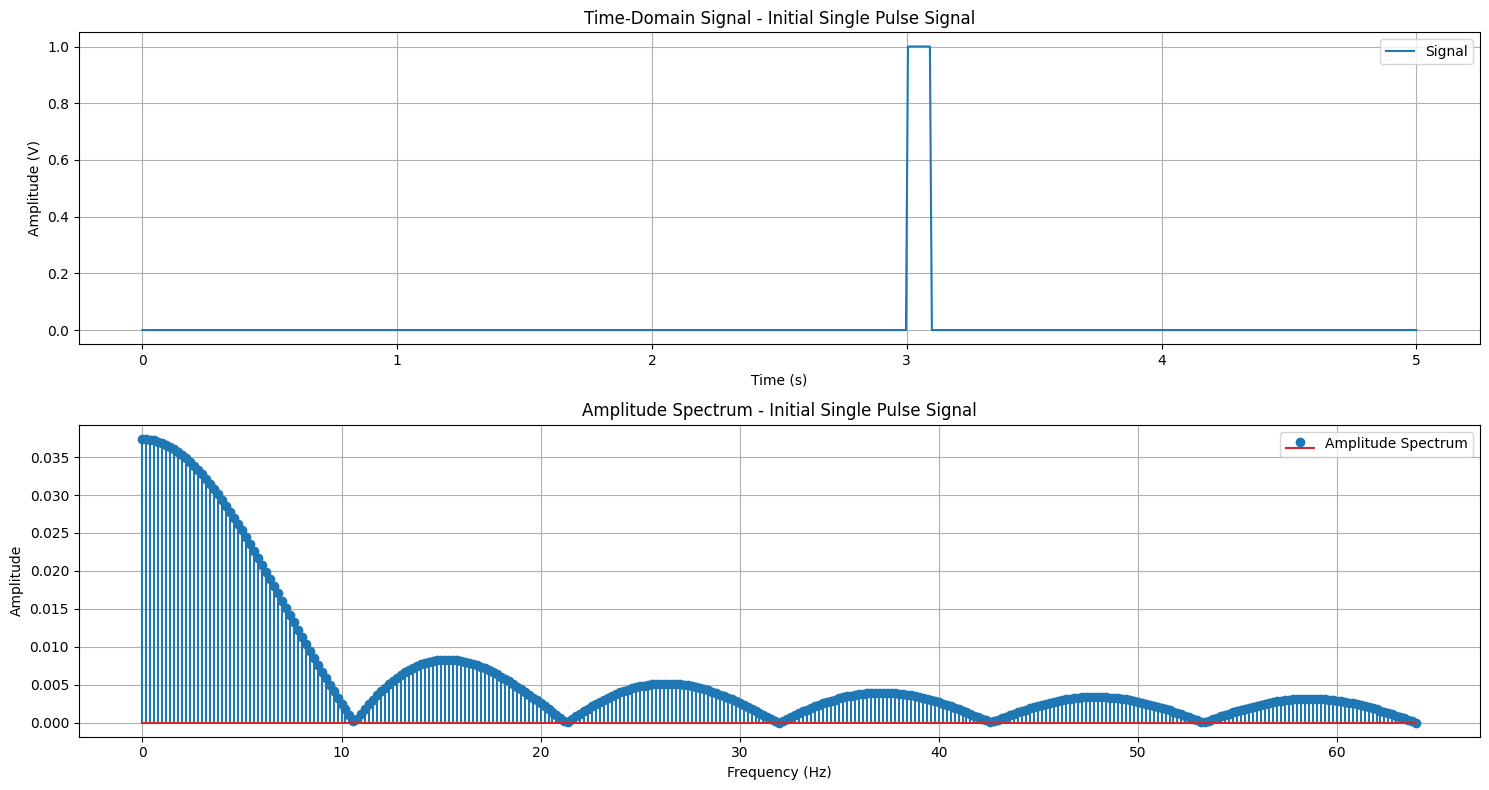

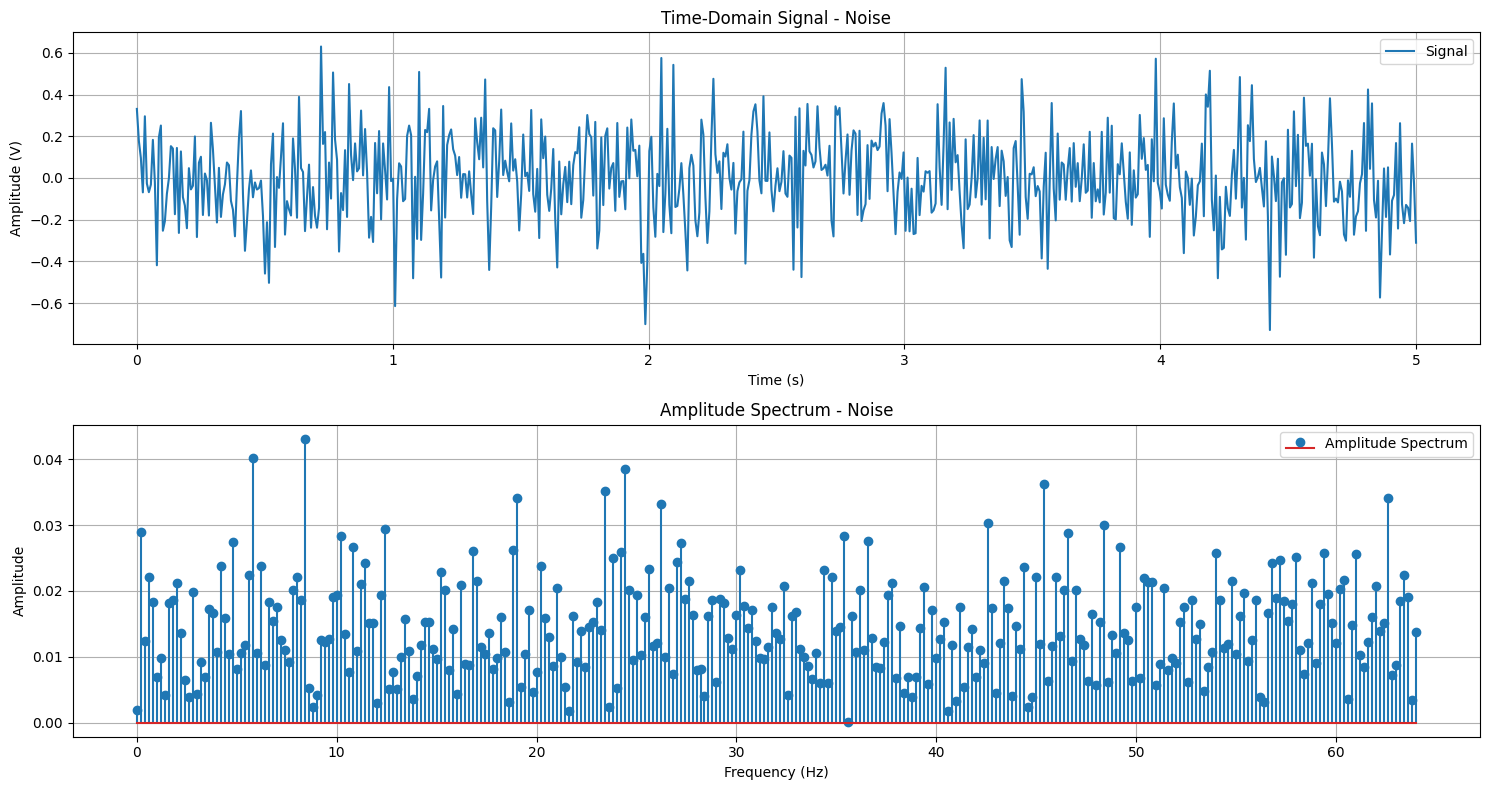

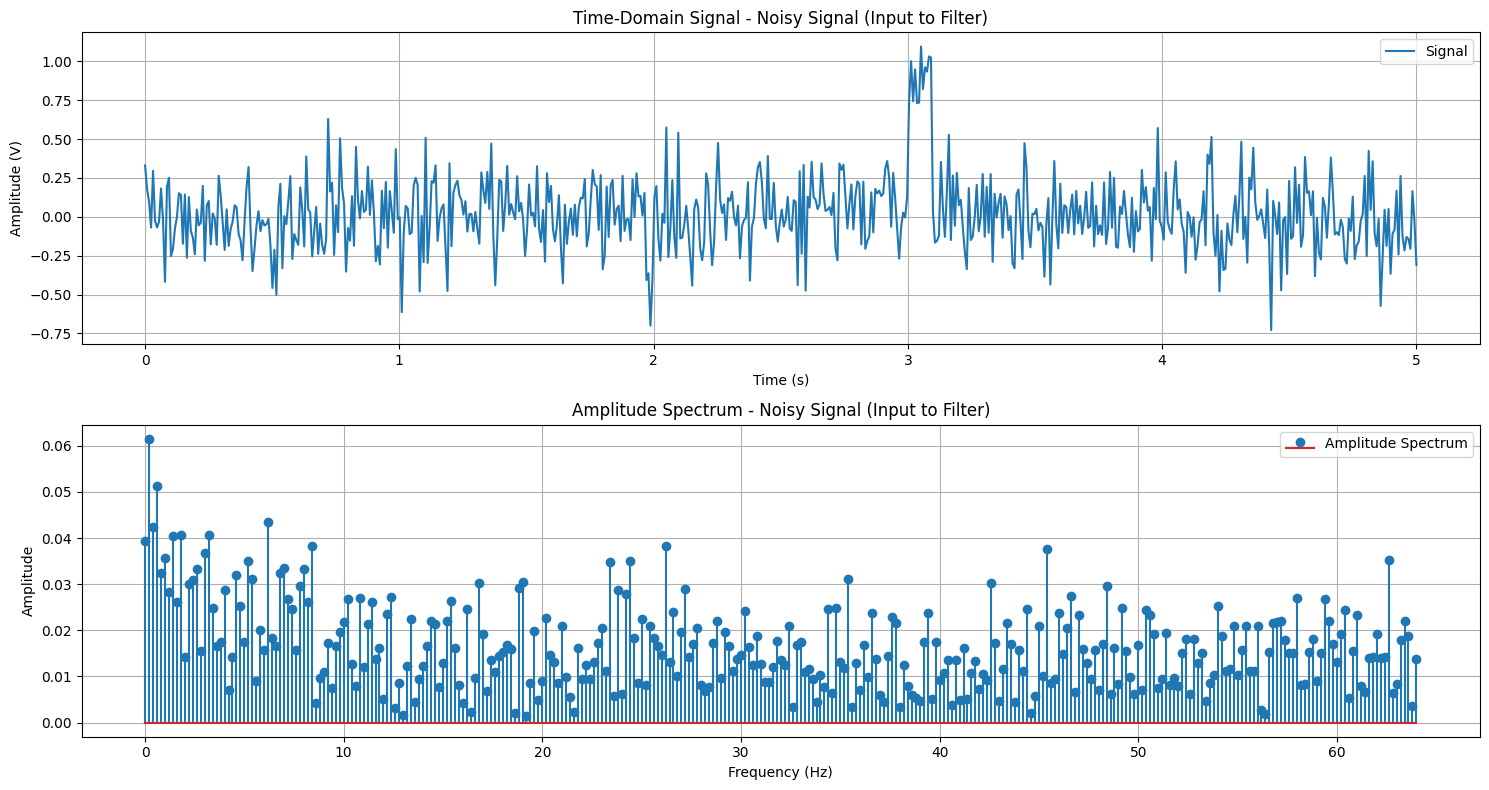

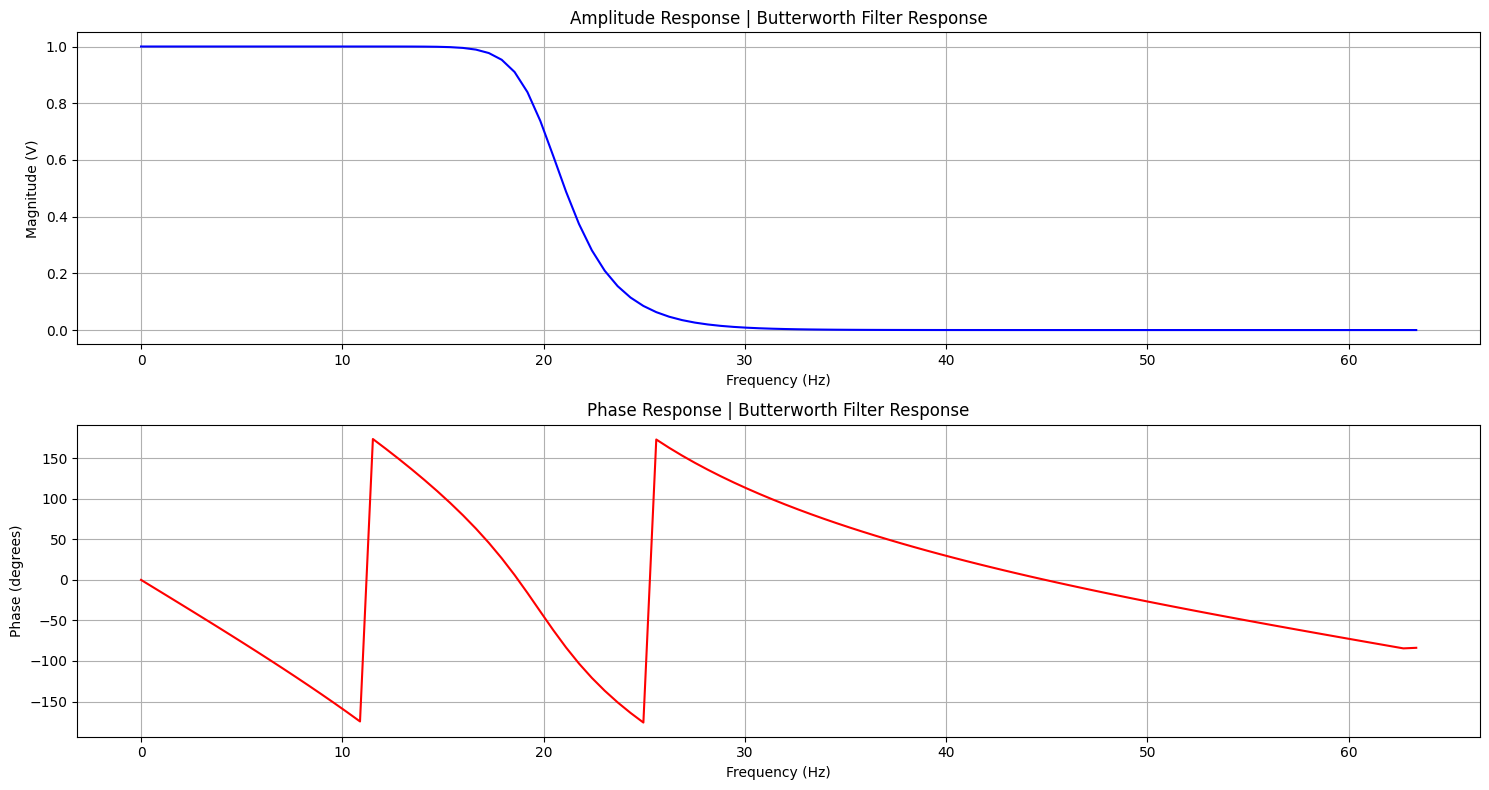

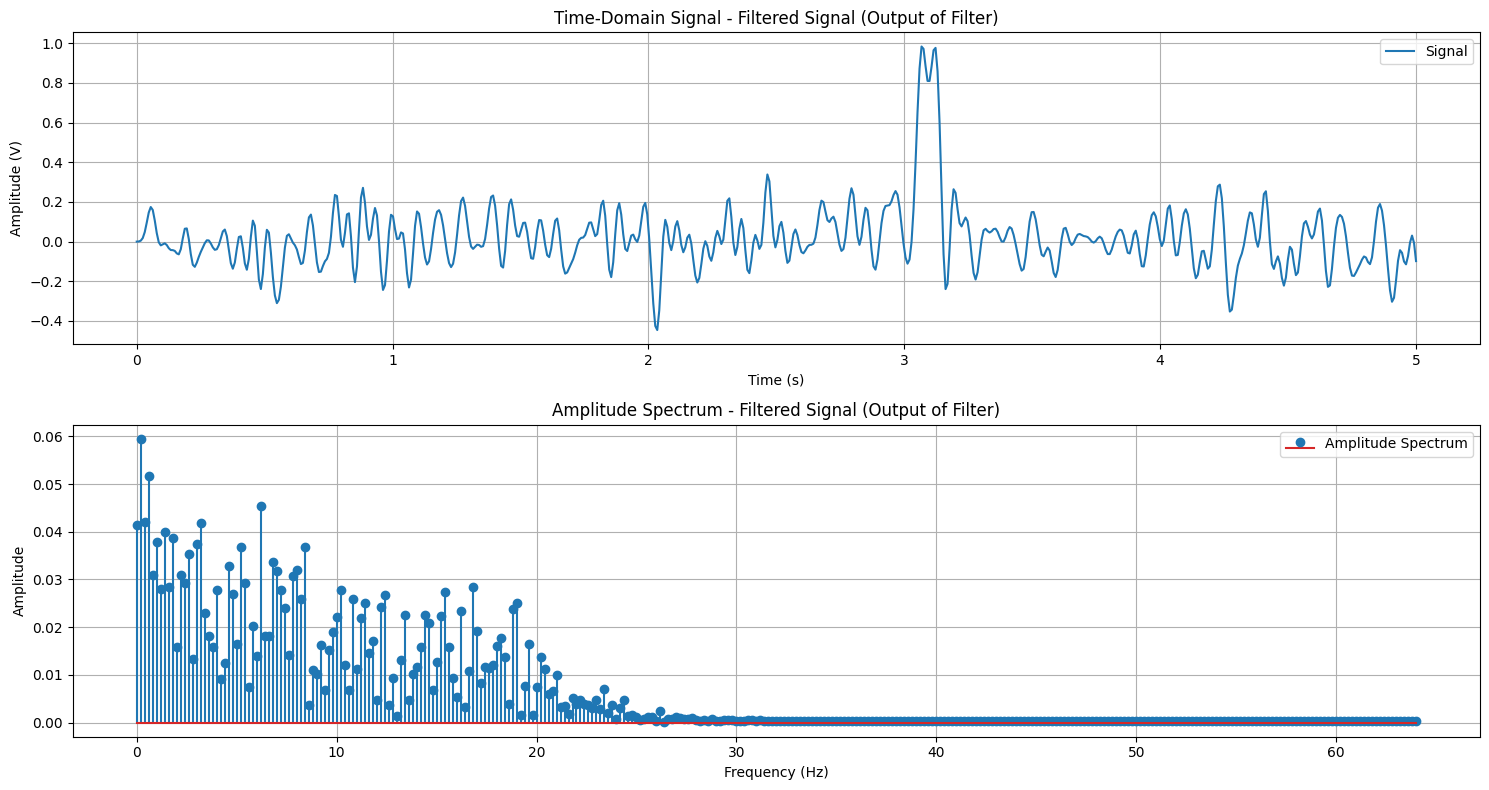

In [220]:
sampling_rate = 128
T = 5

# Single rectangular pulse
time, single_pulse_signal = generate_single_pulse(
    T,
    pulse_amplitude=1,
    pulse_duration=0.1,
    pulse_start=3,
    sampling_rate=sampling_rate
)

# Generate noise
noise_amplitude = 0.2
noise = noise_amplitude * np.random.normal(size=time.size)

# Combine signal and noise
noisy_signal = single_pulse_signal + noise

# Designing Butterworth low-pass filter
wp = 20 / (sampling_rate / 2)  # Passband edge (normalized)
ws = 25 / (sampling_rate / 2)  # Stopband edge (normalized)
gpass = 3  # Maximum allowable gain in passband (dB)
gstop = 20  # Minimum attenuation in stopband (dB)

order, natural_frequency = buttord(wp, ws, gpass, gstop)

if 5 <= order <= 10:
    print(f"Filter order = {order} (within the specified range)")
else:
    print(f"Filter order = {order} (outside the specified range) - Adjust parameters!")

# Designing the filter coefficients
b, a = butter(order, natural_frequency, btype='low')

filtered_signal = lfilter(b, a, noisy_signal)

plot_signal(time, single_pulse_signal, sampling_rate, "Initial Single Pulse Signal")
plot_signal(time, noise, sampling_rate, "Noise")
plot_signal(time, noisy_signal, sampling_rate, "Noisy Signal (Input to Filter)")
amplitude_frequency_response(b, a, sampling_rate, "Butterworth Filter Response")
plot_signal(time, filtered_signal, sampling_rate, "Filtered Signal (Output of Filter)")


In [221]:
input_snr = signal_to_noise_ratio(single_pulse_signal, noise)
output_snr = signal_to_noise_ratio(filtered_signal, filtered_signal - single_pulse_signal)
print(f"Noisy signal to noise ratio: {input_snr:.2f} dB")
print(f"Filtered signal to noise ratio: {output_snr:.2f} dB")

Noisy signal to noise ratio: -3.56 dB
Filtered signal to noise ratio: -0.26 dB


Here we can see the positive effect of filtering: the power of the filtered signal is now higher than the noise.

# Task 2

2. Сформувати вектор відліків часу тривалістю 1 с для частоти дискретизації 128
Гц. Сформувати сигнали ділянки синусоїди частотою 10 Гц амплітуди 1 В. Додати
випадковий сигнал з нульовим середнім значенням амплітуди 1 В. Спроектувати ФНЧ,
ФВЧ та СФ Чебишова І роду для позбавлення сигналу від шуму (cheb1ord, cheby1).

In [222]:
sampling_rate = 128
nyquist = sampling_rate / 2
T = 1
frequency = 10
signal_amplitude, noise_amplitude = 1, 1

In [223]:
time, sinusoidal_signal = generate_sinusoidal_signal(frequency, T, sampling_rate)
sinusoidal_signal = signal_amplitude * sinusoidal_signal

noise = noise_amplitude * np.random.normal(size=time.size)
noisy_signal = sinusoidal_signal + noise

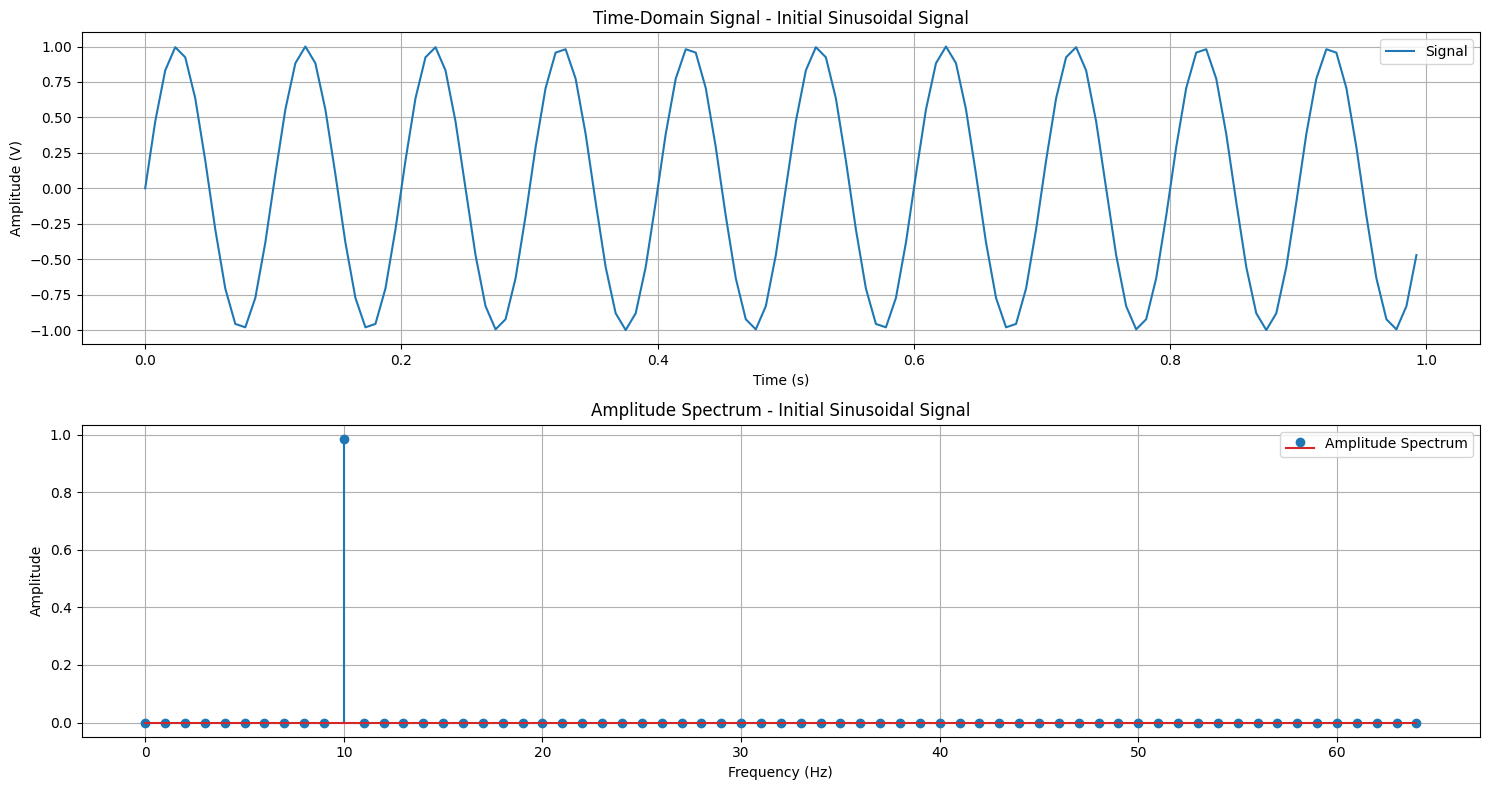

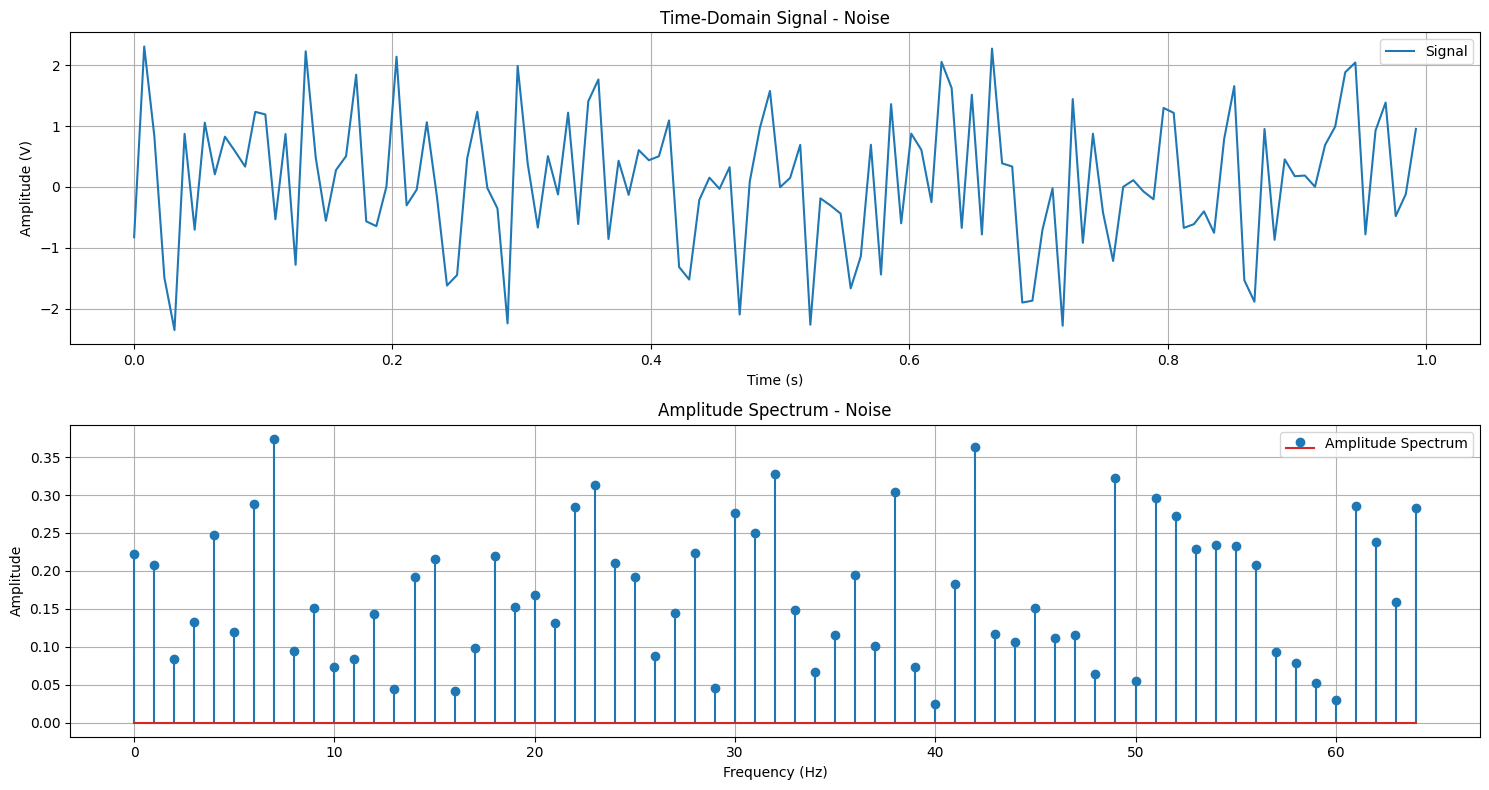

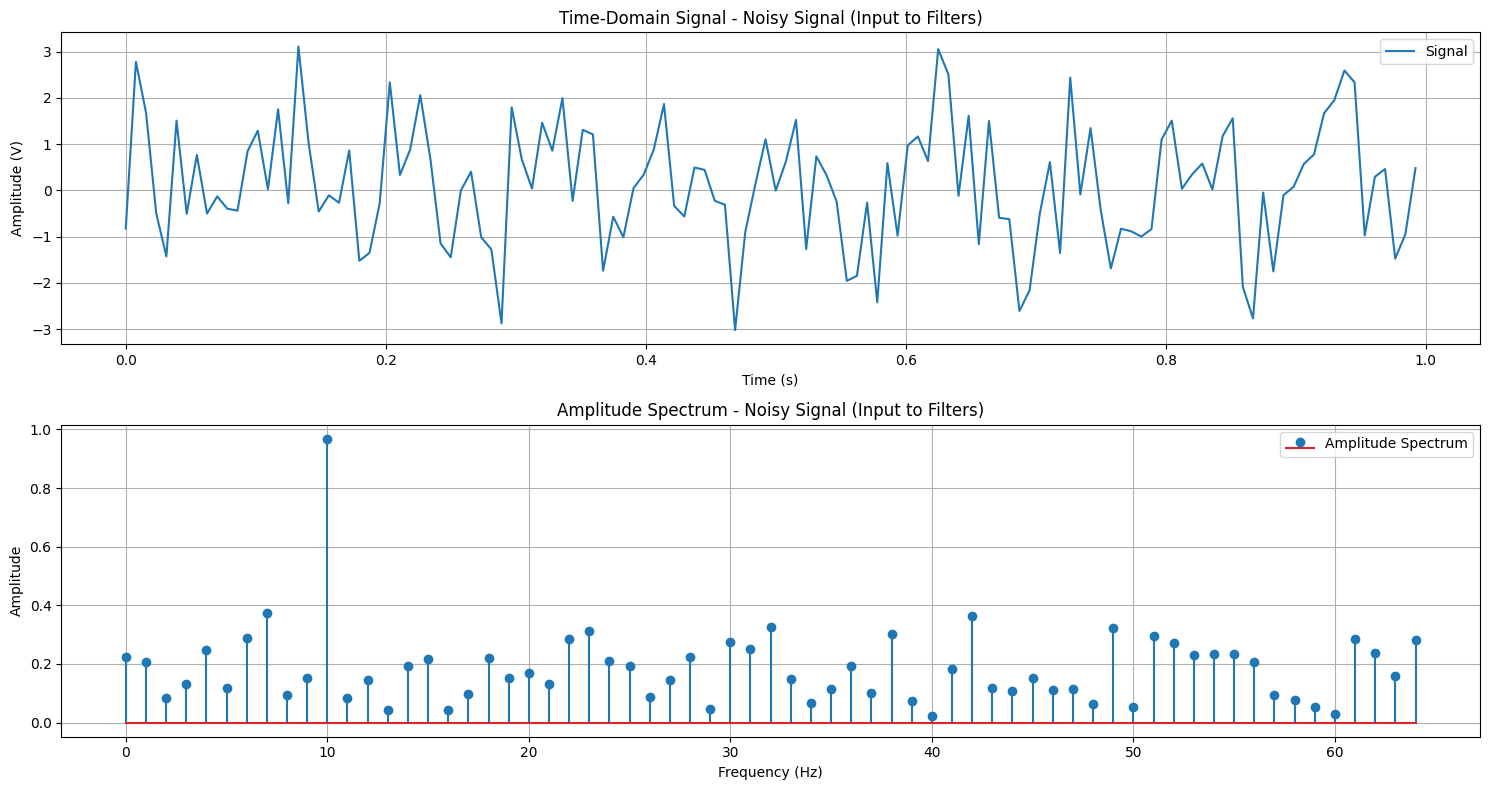

In [224]:
plot_signal(time, sinusoidal_signal, sampling_rate, "Initial Sinusoidal Signal")
plot_signal(time, noise, sampling_rate, "Noise")
plot_signal(time, noisy_signal, sampling_rate, "Noisy Signal (Input to Filters)")

In [225]:
# Filter specifications
gpass = 3
gstop = 20

# Filter design parameters
wp_lp, ws_lp = 20 / nyquist, 23 / nyquist  # Low-pass
wp_hp, ws_hp = 9 / nyquist, 11 / nyquist  # High-pass
wp_bp, ws_bp = [8 / nyquist, 14 / nyquist], [5 / nyquist, 15 / nyquist]  # Band-pass

# Filter design and order checks
filter_params = [
    ("Low Pass Filter", wp_lp, ws_lp, 'low'),
    ("High Pass Filter", wp_hp, ws_hp, 'high'),
    ("Bandpass Filter", wp_bp, ws_bp, 'bandpass')
]

filters = {}
for title, wp, ws, btype in filter_params:
    order, natural_frequency = cheb1ord(wp, ws, gpass, gstop)
    if 5 <= order <= 10:
        print(f"{title} order is {order}, which is within the specified range.")
    else:
        print(f"{title} order is {order}, which is outside the specified range. Adjust gstop or gpass and retry.")
    b, a = cheby1(order, gpass, natural_frequency, btype=btype)
    filters[title] = (b, a)

filtered_signals = {}
for title, (b, a) in filters.items():
    filtered_signals[title] = lfilter(b, a, noisy_signal)

Low Pass Filter order is 5, which is within the specified range.
High Pass Filter order is 5, which is within the specified range.
Bandpass Filter order is 5, which is within the specified range.


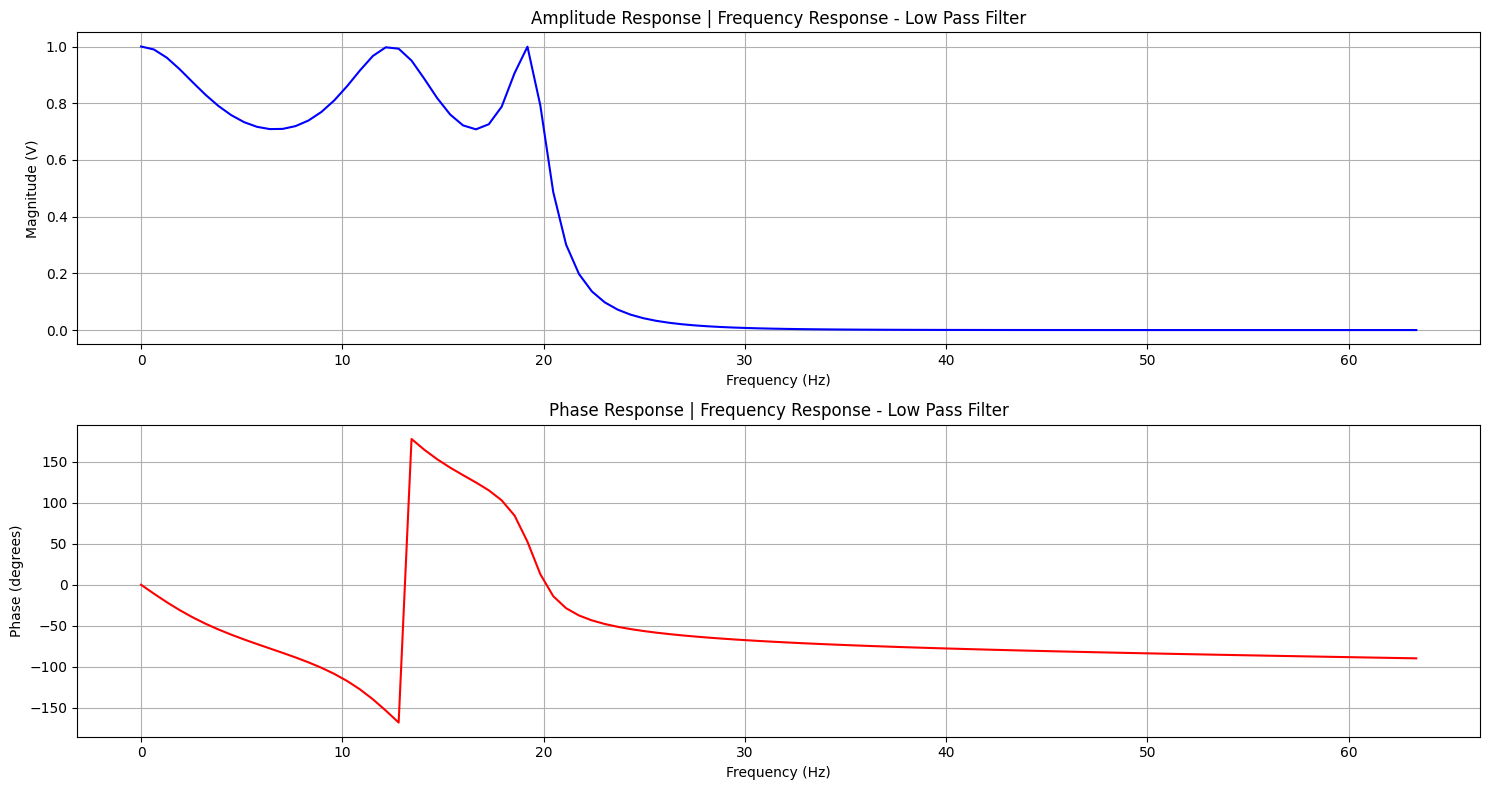

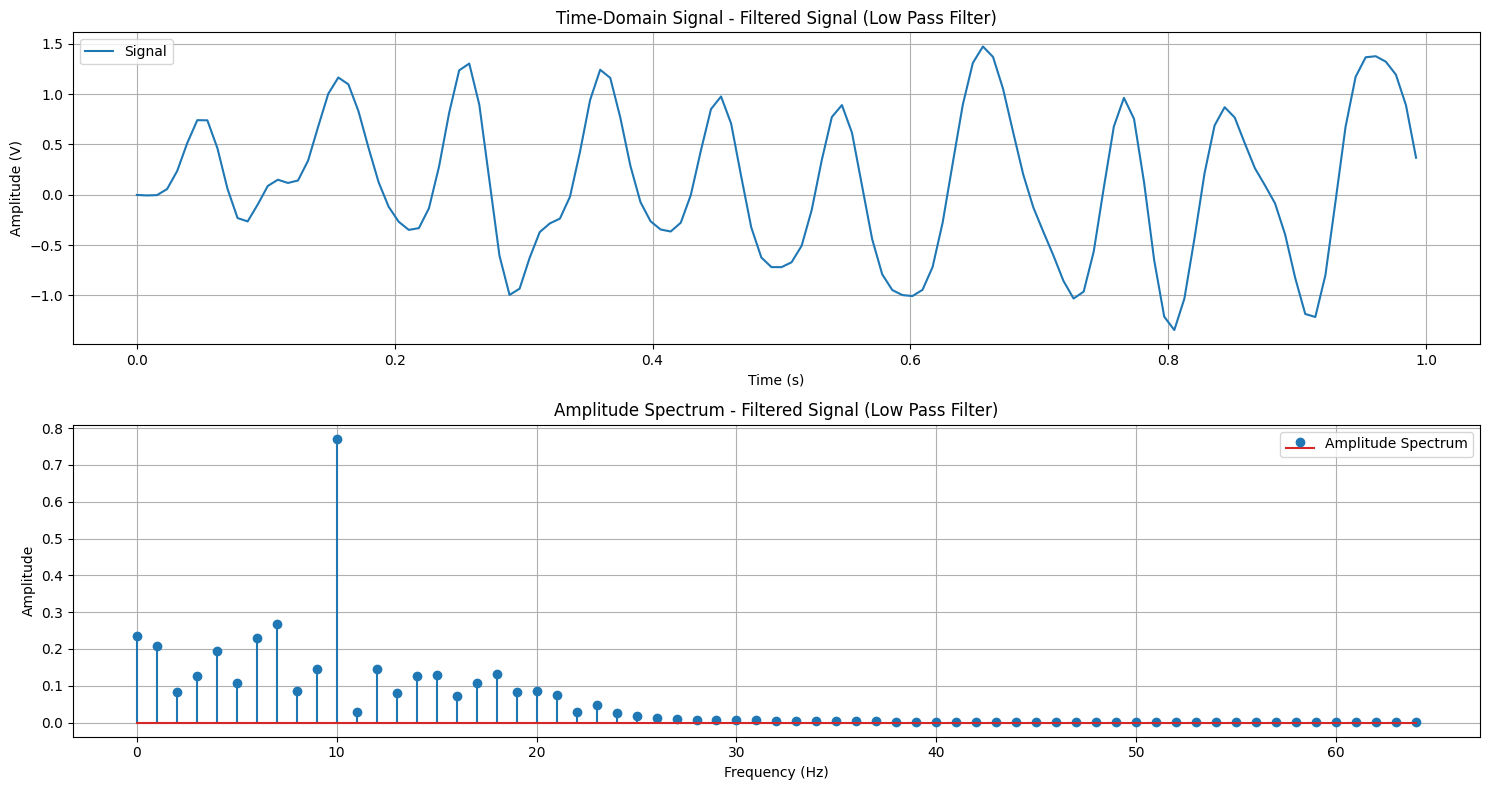

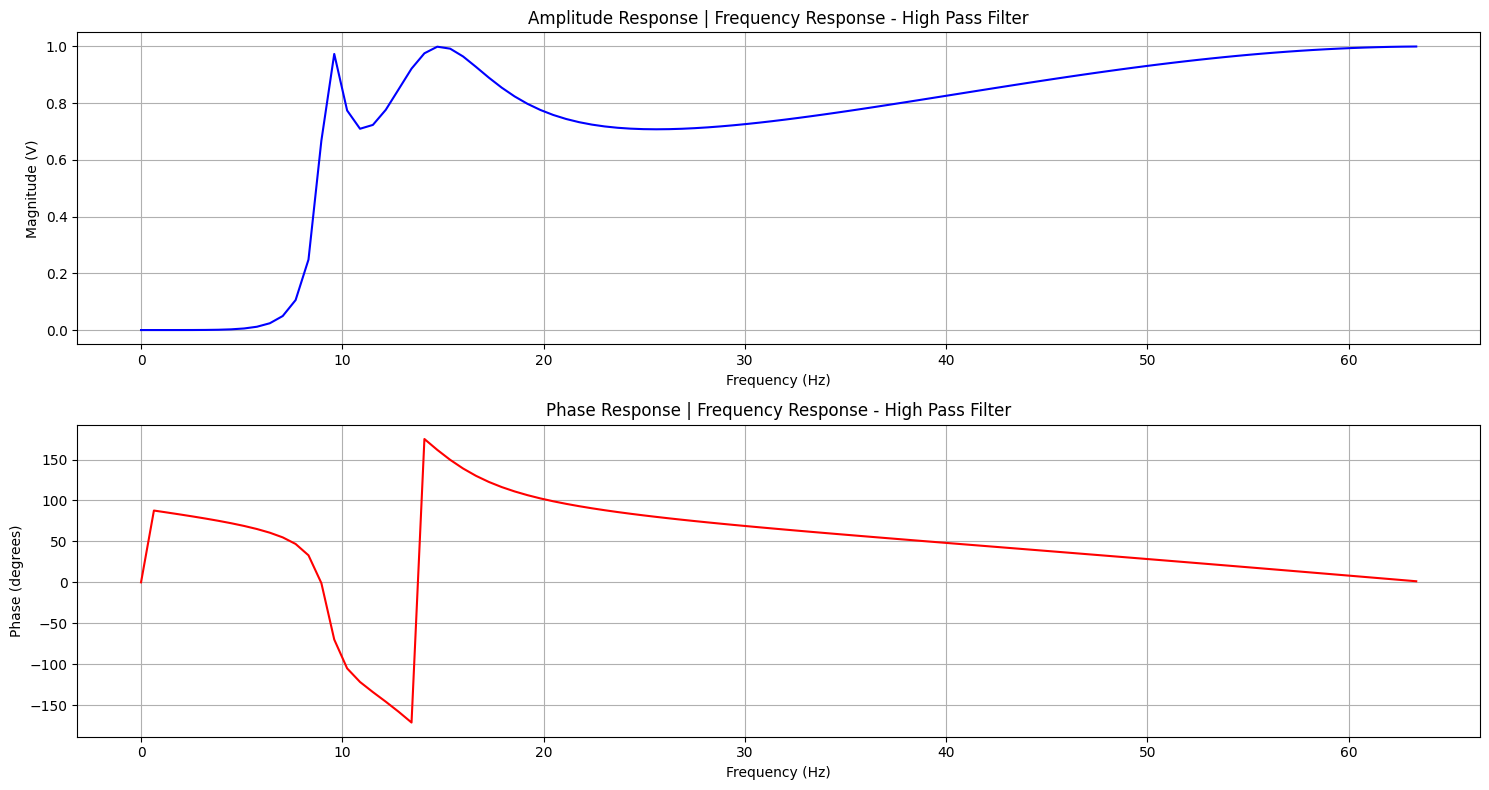

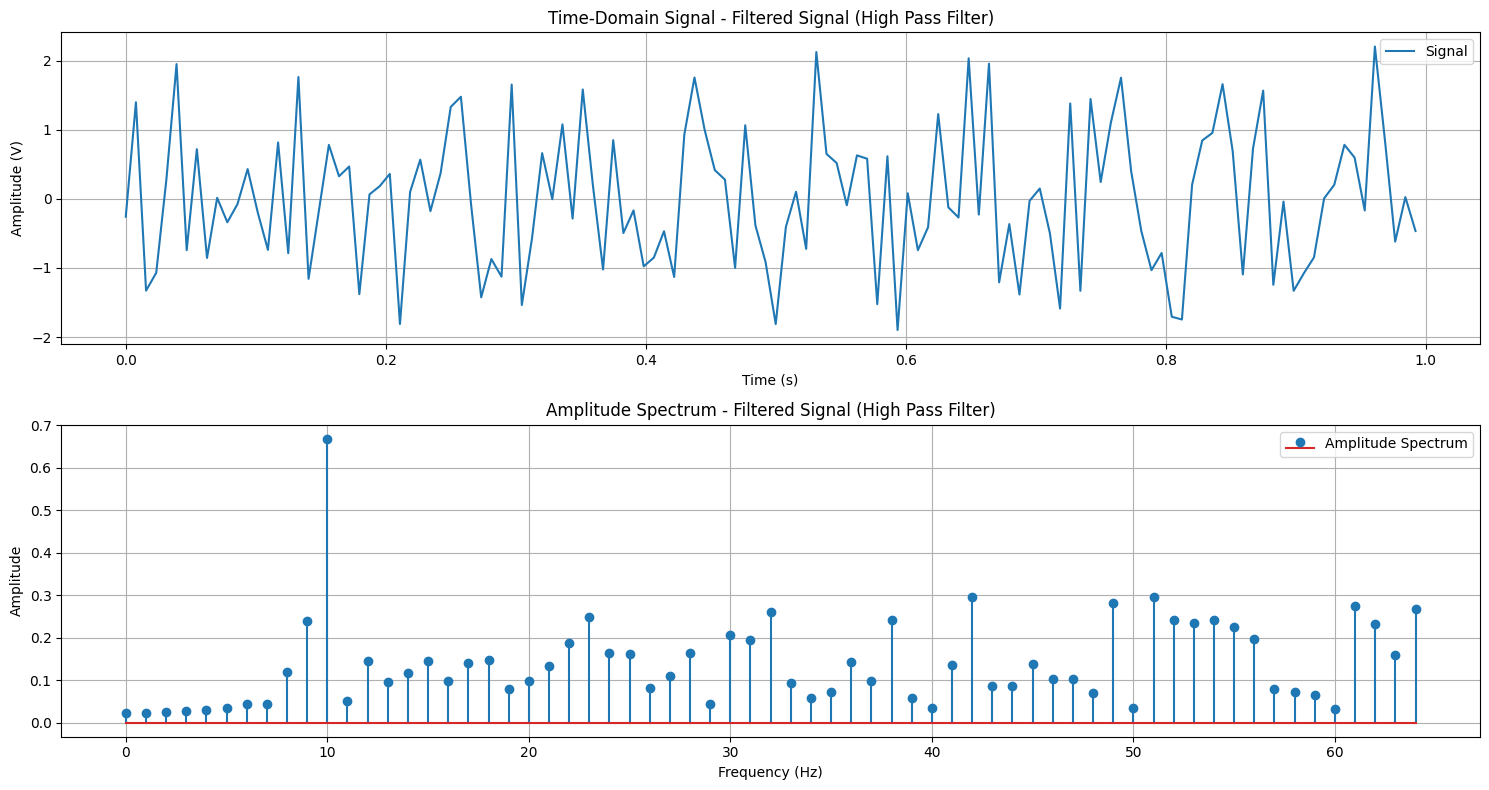

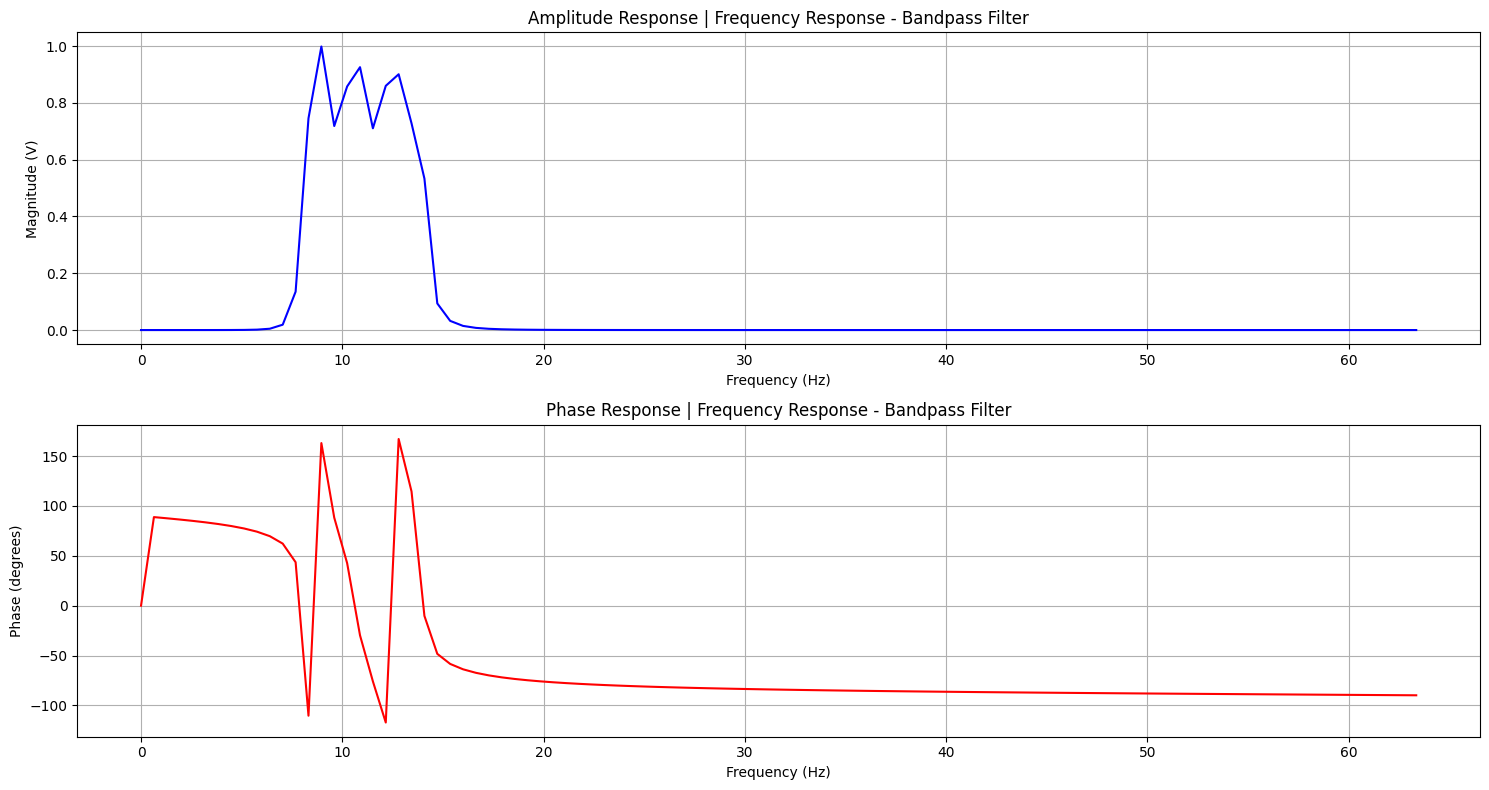

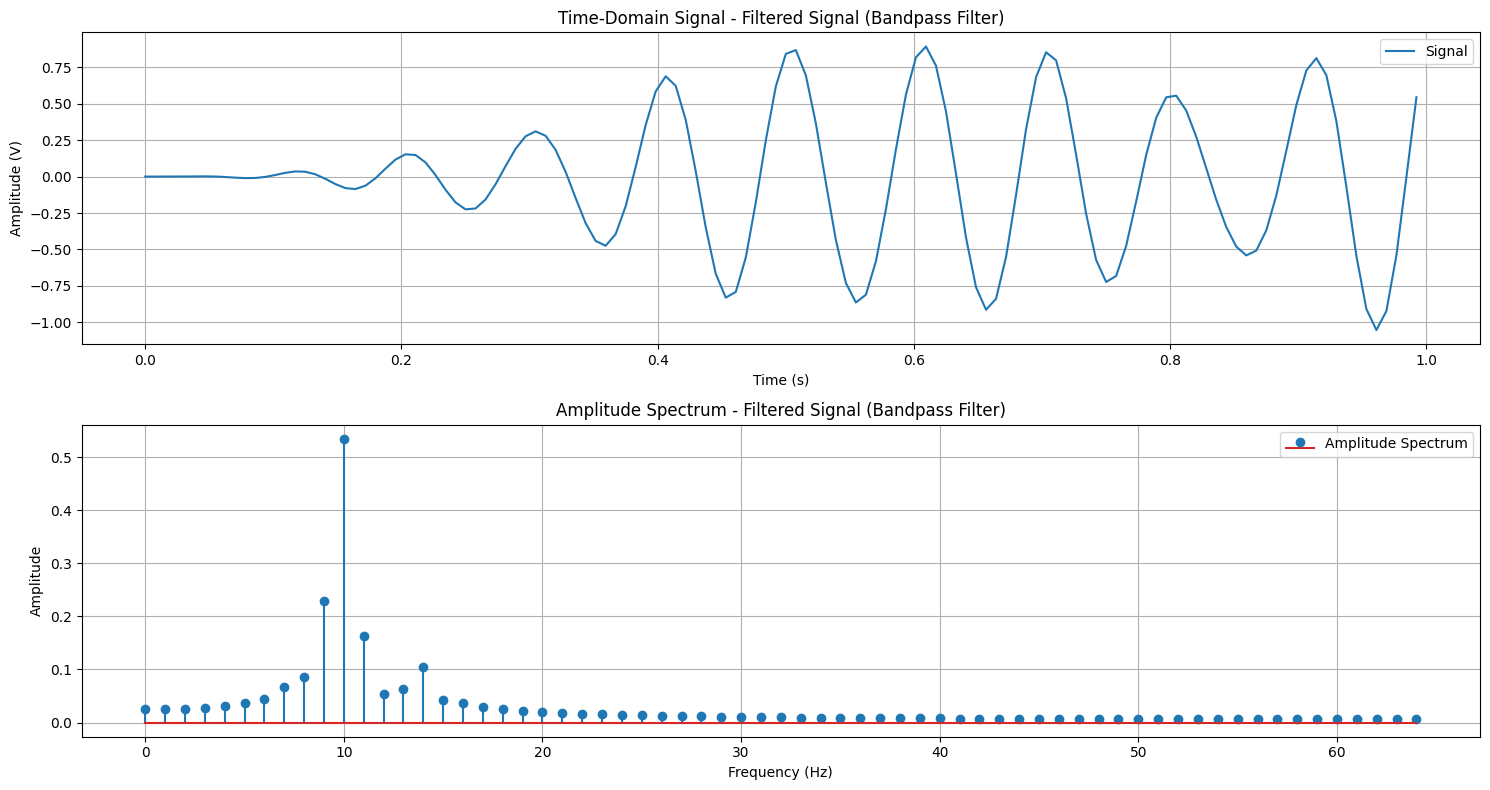

In [226]:
for title, (b, a) in filters.items():
    amplitude_frequency_response(b, a, sampling_rate, title=f"Frequency Response - {title}")
    plot_signal(time, filtered_signals[title], sampling_rate, f"Filtered Signal ({title})")

In [227]:
input_snr = signal_to_noise_ratio(sinusoidal_signal, noise)
print(f"Noisy signal to noise ratio: {input_snr:.2f} dB")

for title, filtered_signal in filtered_signals.items():
    output_snr = signal_to_noise_ratio(filtered_signal, filtered_signal - sinusoidal_signal)
    print(f"{title}: Filtered signal to noise ratio: {output_snr:.2f} dB")


Noisy signal to noise ratio: -3.90 dB
Low Pass Filter: Filtered signal to noise ratio: -3.96 dB
High Pass Filter: Filtered signal to noise ratio: -1.52 dB
Bandpass Filter: Filtered signal to noise ratio: -3.66 dB


High-pass filter showed the best ratio for 10 times in a row, which suggests that it is the "best" choice for the given conditions, although bandpass filter has a smoother output and amplitude spectrum.

## Task 3

3. Сформувати вектор відліків часу тривалістю 10 с для частоти дискретизації 128 Гц. Сформувати випадковий сигнал амплітуди 10 мВ з нульовим середнім значенням, який зашумлений мережевою перешкодою частоти 50 Гц амплітуди 1 В. Спроектувати ЗФ Батерворта для позбавлення сигналу від перешкоди.

In [228]:
sampling_rate = 128
nyquist = sampling_rate / 2
T = 10
frequency = 10


time, _ = generate_sinusoidal_signal(frequency, T, sampling_rate)

random_signal = np.random.normal(0, 0.01, time.size)

noise = np.sin(2 * np.pi * 50 * time)
noisy_signal = random_signal + noise


In [229]:
wp1 = 45 / nyquist  # Lower edge of the passband
wp2 = 55 / nyquist  # Upper edge of the passband
ws1 = 48 / nyquist  # Lower edge of the stopband
ws2 = 52 / nyquist  # Upper edge of the stopband

gpass = 3  # Max loss in passband (dB)
gstop = 40  # Min attenuation in stopband (dB)


order_bs, wn_bs = buttord([wp1, wp2], [ws1, ws2], gpass, gstop)

title = "Bandstop filter"
if 5 <= order_bs <= 10:
    print(f"{title} order = {order}, (within the specified range)")
else:
    print(f"{title} order = {order}, (outside the specified range)")


b_bs, a_bs = butter(order_bs, wn_bs, btype='bandstop', analog=False)

filtered_signal_bs = lfilter(b_bs, a_bs, noisy_signal)

Bandstop filter order = 5, (within the specified range)


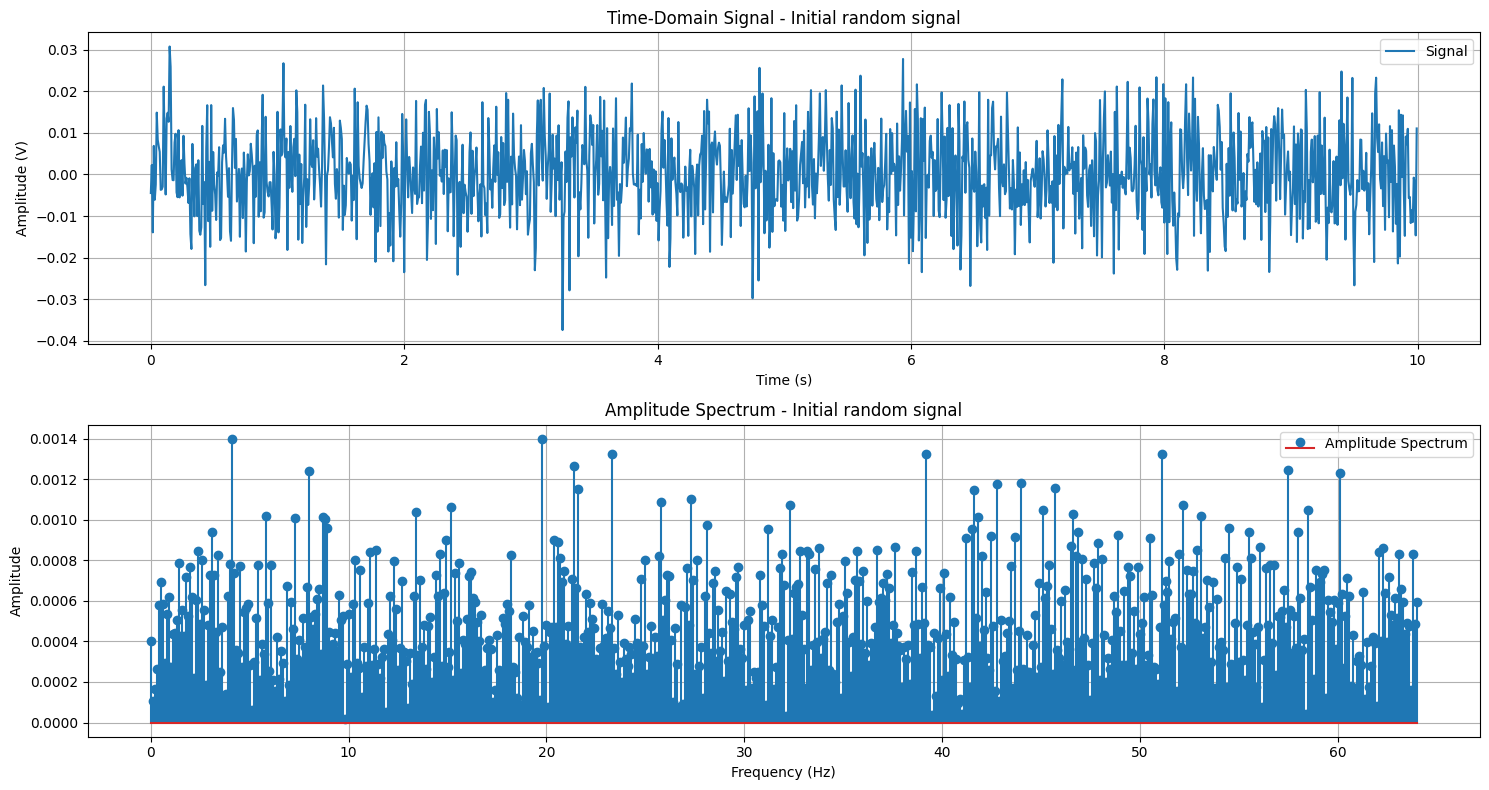

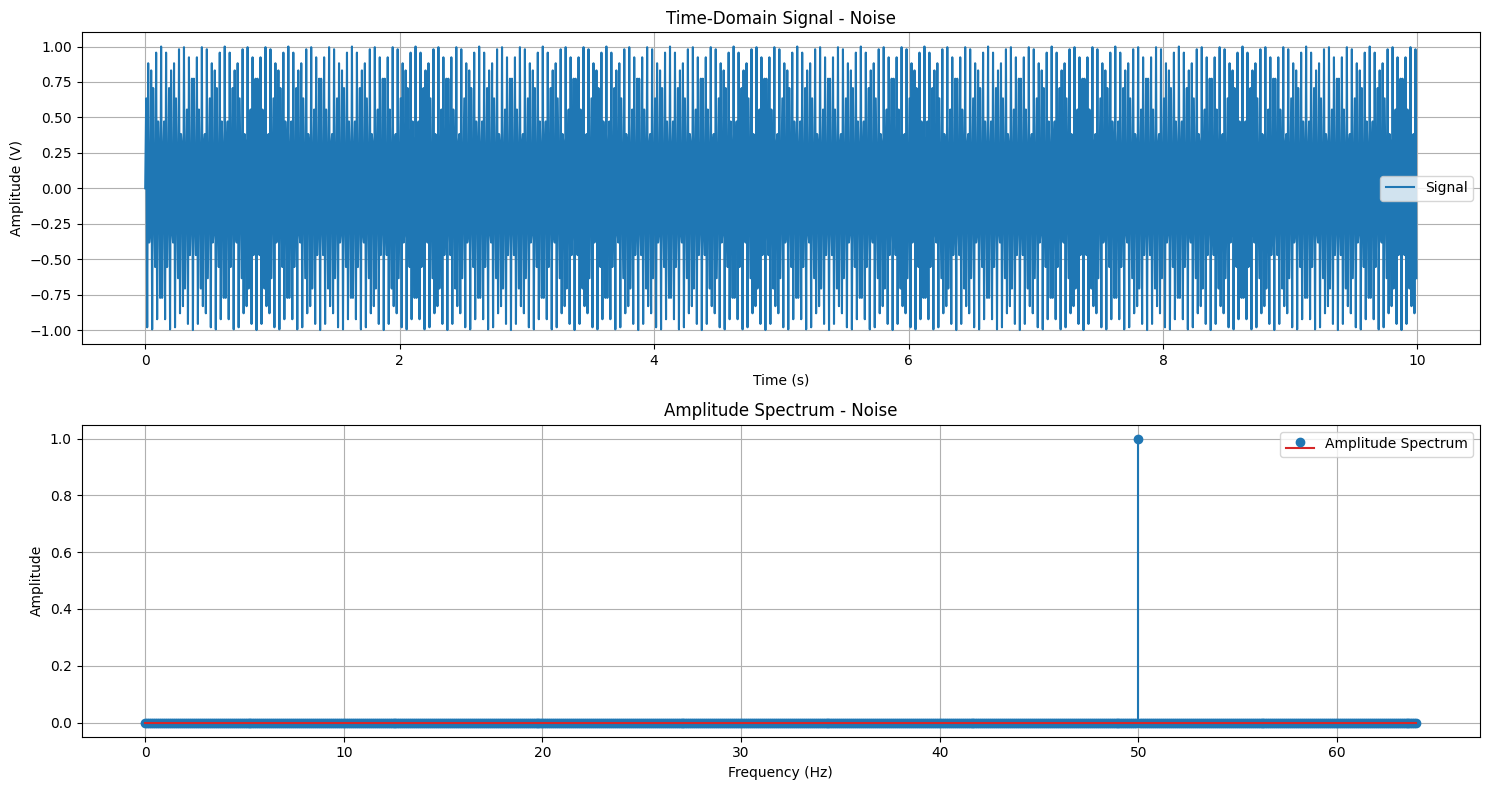

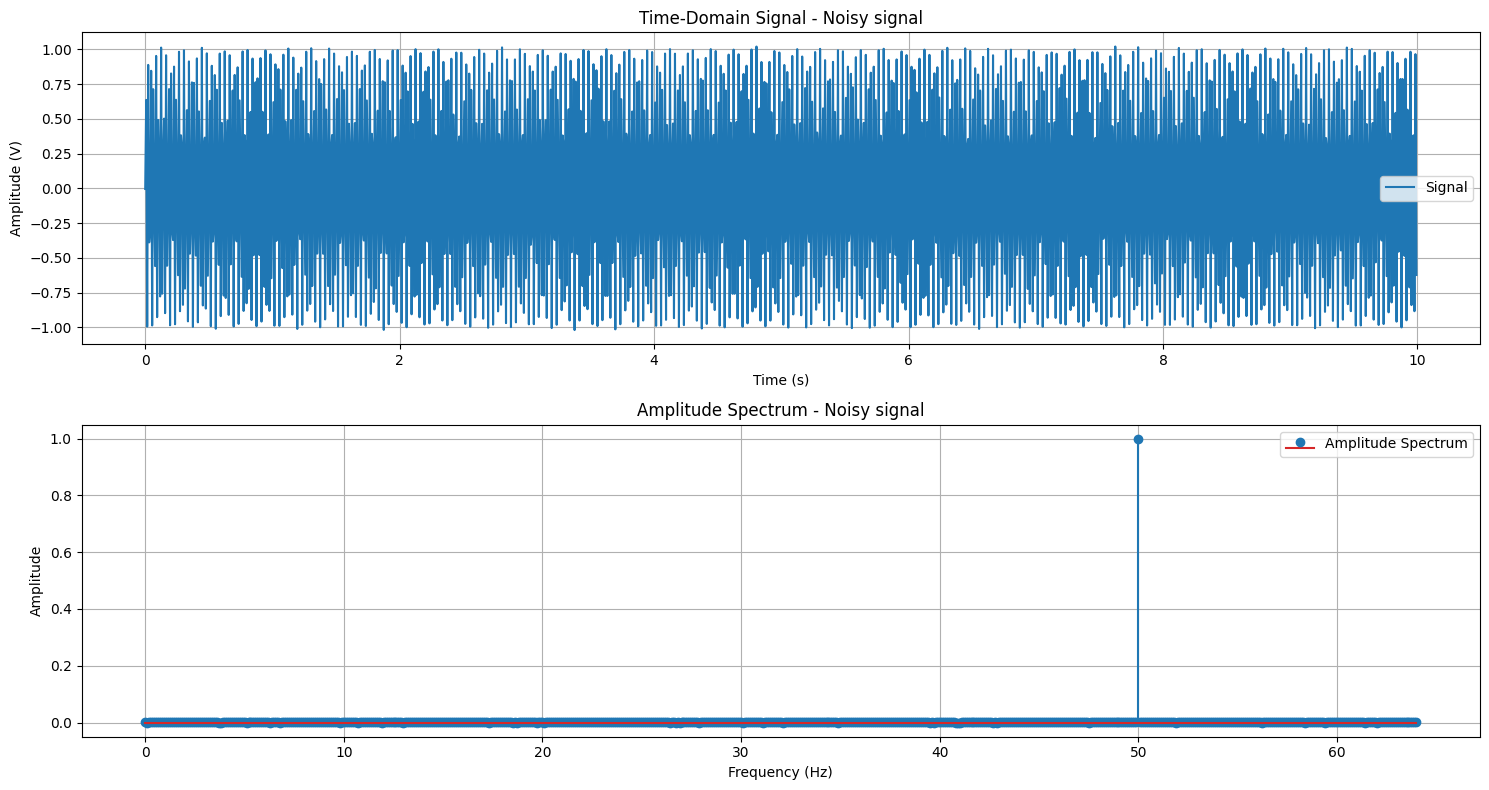

In [230]:
plot_signal(time, random_signal, sampling_rate, "Initial random signal")
plot_signal(time, noise, sampling_rate, "Noise")
plot_signal(time, noisy_signal, sampling_rate, "Noisy signal")

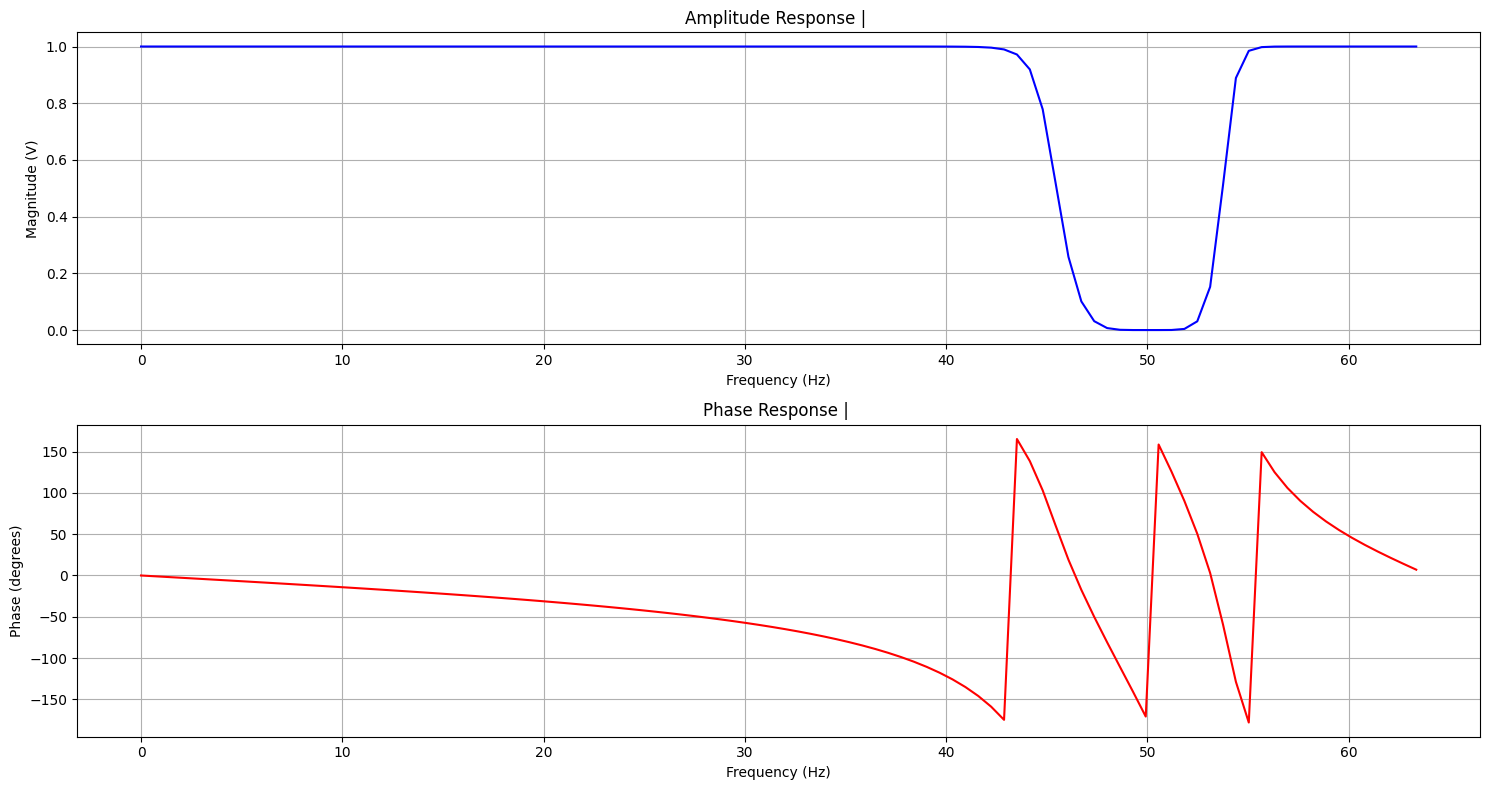

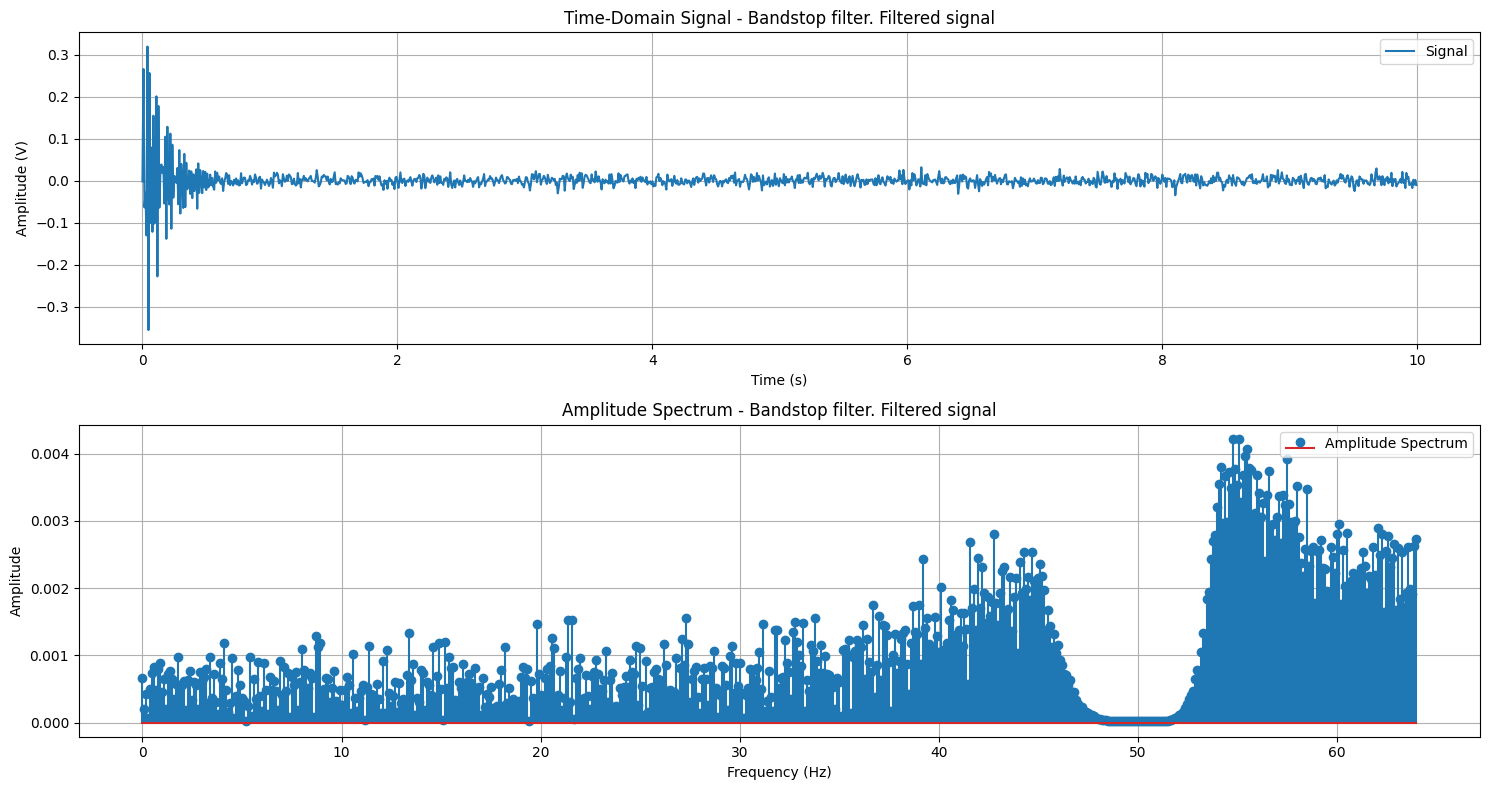

In [231]:
amplitude_frequency_response(b_bs, a_bs, sampling_rate)
plot_signal(time, filtered_signal_bs, sampling_rate, "Bandstop filter. Filtered signal")

In [232]:
from scipy.signal import iirnotch

f0 = 50
Q = 5

b_notch, a_notch = iirnotch(f0, Q, sampling_rate)
filtered_signal_notch = lfilter(b_notch, a_notch, noisy_signal)

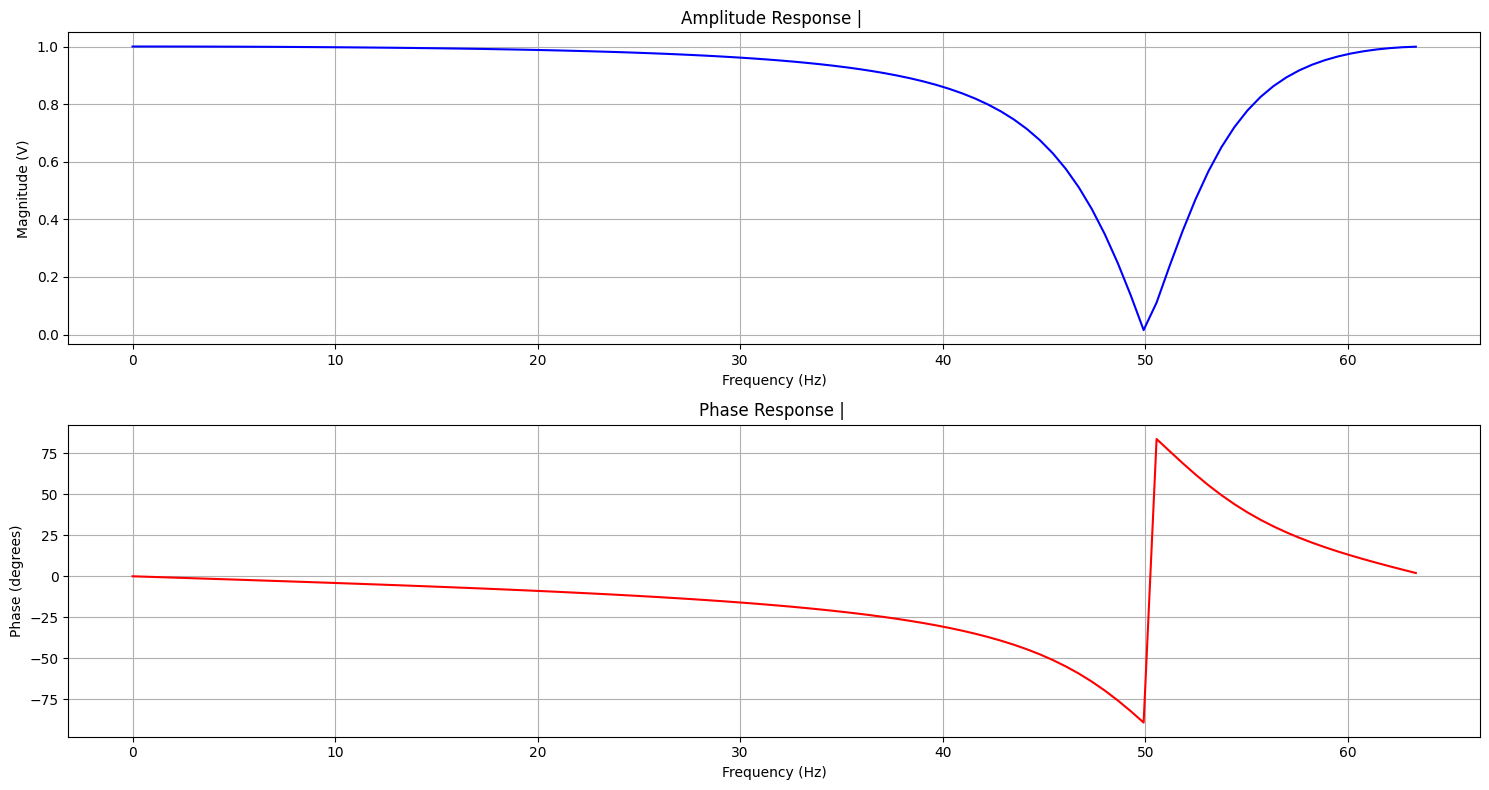

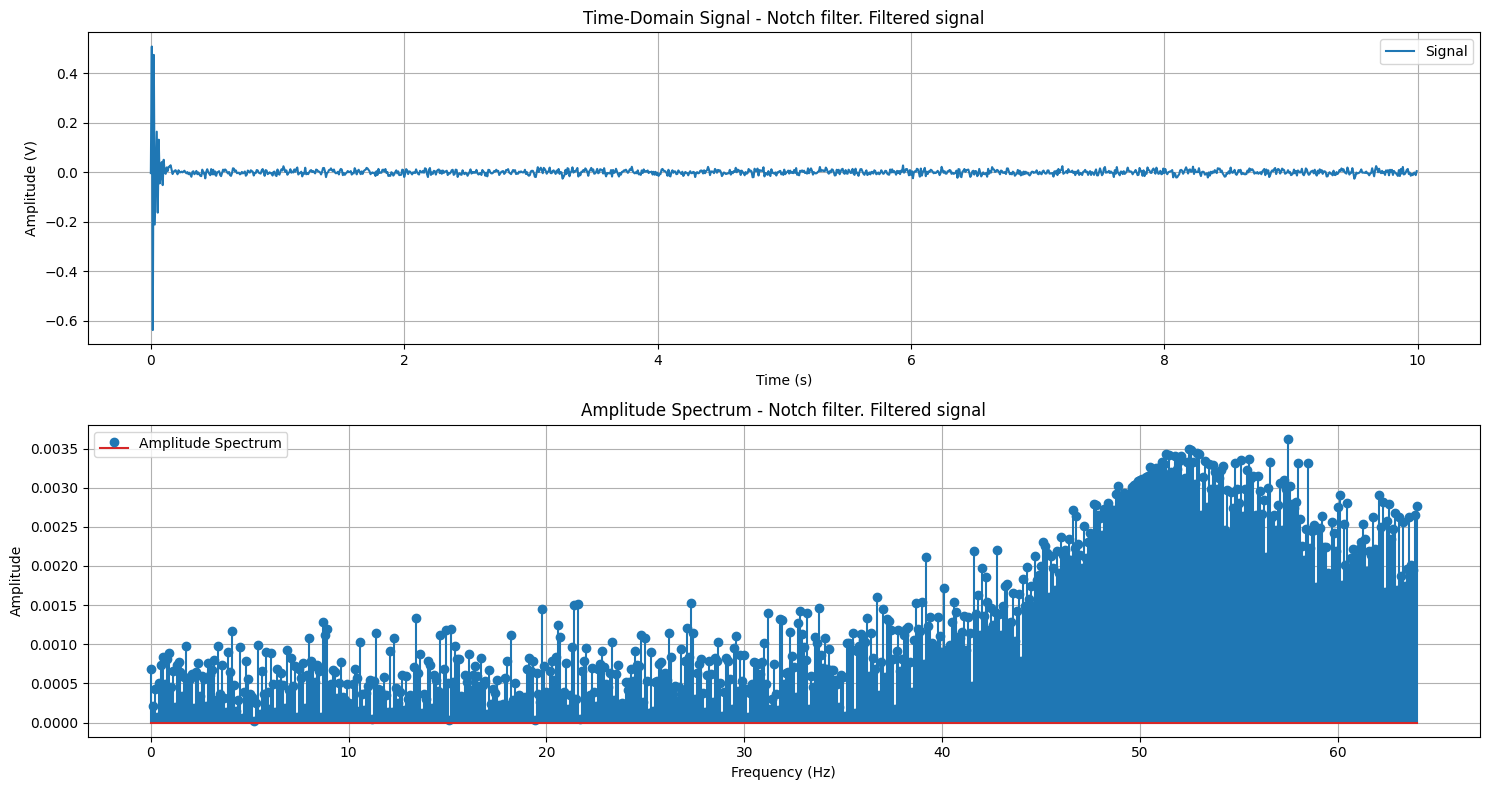

In [233]:
amplitude_frequency_response(b_notch, a_notch, sampling_rate)

plot_signal(time, filtered_signal_notch, sampling_rate, "Notch filter. Filtered signal")

## Task 4

4. Для звукових сигналів, які отримані з різною частотою дискретизації, виконати допомогою фільтрів розділення на три спектральні діапазони: до 450 Гц; від 450 Гц до 1 кГц; від 1 кГц до 4 кГц. Прослухати отримані сигнали в діапазонах, зробити висновки.

In [234]:
import math

def play_audio(recording, samplerate):
    recording_normalized = np.int16(recording / np.max(np.abs(recording)) * (math.pow(2, 15) - 1))

    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=samplerate,
                    output=True)

    stream.write(recording_normalized.tobytes())
    stream.stop_stream()
    stream.close()
    p.terminate()

# Filter design functions
def design_lowpass_filter(cutoff, sampling_rate, order=5):
    nyquist = sampling_rate / 2
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, sampling_rate, order=5):
    b, a = design_lowpass_filter(cutoff, sampling_rate, order=order)
    y = lfilter(b, a, data)
    return y

def design_bandpass_filter(lowcut, highcut, sampling_rate, order=5):
    nyquist = sampling_rate / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, Wn=[low, high], btype='bandpass', analog=False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, sampling_rate, order=5):
    b, a = design_bandpass_filter(lowcut, highcut, sampling_rate, order=order)
    y = lfilter(b, a, data)
    return y

In [235]:
audio_44100_hz = np.load('audio/5_sec_44100_hz.npy')
audio_8000_hz = np.load('audio/5_sec_8000_hz.npy')

sampling_rate_44100 = 44100
sampling_rate_8000 = 8000

# Filtering signals for 44,100 Hz audio
filtered_signal_lp_44100 = butter_lowpass_filter(audio_44100_hz, 450, sampling_rate_44100)
filtered_signal_bp1_44100 = butter_bandpass_filter(audio_44100_hz, 450, 1000, sampling_rate_44100)
filtered_signal_bp2_44100 = butter_bandpass_filter(audio_44100_hz, 1000, 4000, sampling_rate_44100)

# Filtering signals for 8,000 Hz audio
filtered_signal_lp_8000 = butter_lowpass_filter(audio_8000_hz, 450, sampling_rate_8000)
filtered_signal_bp1_8000 = butter_bandpass_filter(audio_8000_hz, 450, 1000, sampling_rate_8000)
filtered_signal_bp2_8000 = butter_bandpass_filter(audio_8000_hz, 1000, 3999, sampling_rate_8000)

filtered_signals = {
    "Low Pass 44,100 Hz": (filtered_signal_lp_44100, sampling_rate_44100),
    "Bandpass 450-1,000 Hz 44,100 Hz": (filtered_signal_bp1_44100, sampling_rate_44100),
    "Bandpass 1,000-4,000 Hz 44,100 Hz": (filtered_signal_bp2_44100, sampling_rate_44100),
    "Low Pass 8,000 Hz": (filtered_signal_lp_8000, sampling_rate_8000),
    "Bandpass 450-1,000 Hz 8,000 Hz": (filtered_signal_bp1_8000, sampling_rate_8000),
    "Bandpass 1,000-4,000 Hz 8,000 Hz": (filtered_signal_bp2_8000, sampling_rate_8000),
}

In [236]:
for name, (signal, rate) in filtered_signals.items():
    print(f"Playing: {name}")
    play_audio(signal, rate)

Playing: Low Pass 44,100 Hz
Playing: Bandpass 450-1,000 Hz 44,100 Hz
Playing: Bandpass 1,000-4,000 Hz 44,100 Hz
Playing: Low Pass 8,000 Hz
Playing: Bandpass 450-1,000 Hz 8,000 Hz
Playing: Bandpass 1,000-4,000 Hz 8,000 Hz


The best sound was in the bandpass-filtered signal between 1000 and 4000 Hz, with sampling rate = 8000